neuralnetwork\Scripts\Activate.bat

IMPORTS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [3]:
import time

In [4]:
import pathlib

PREPARING DATASET

In [5]:
traindata_dir = pathlib.Path('archive/train').with_suffix('')

In [6]:
valdata_dir = pathlib.Path('archive/val').with_suffix('')

In [7]:
image_count = len(list(traindata_dir.glob('*/*.jpg')))
print(image_count)
batch_size = 32
img_height = 224
img_width = 224
print(traindata_dir)


21000
archive\train


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    traindata_dir,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size 
)

Found 21000 files belonging to 30 classes.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  valdata_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 30 classes.


In [38]:
class_names = train_ds.class_names
print(class_names)


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

VISUALIZING DATASET

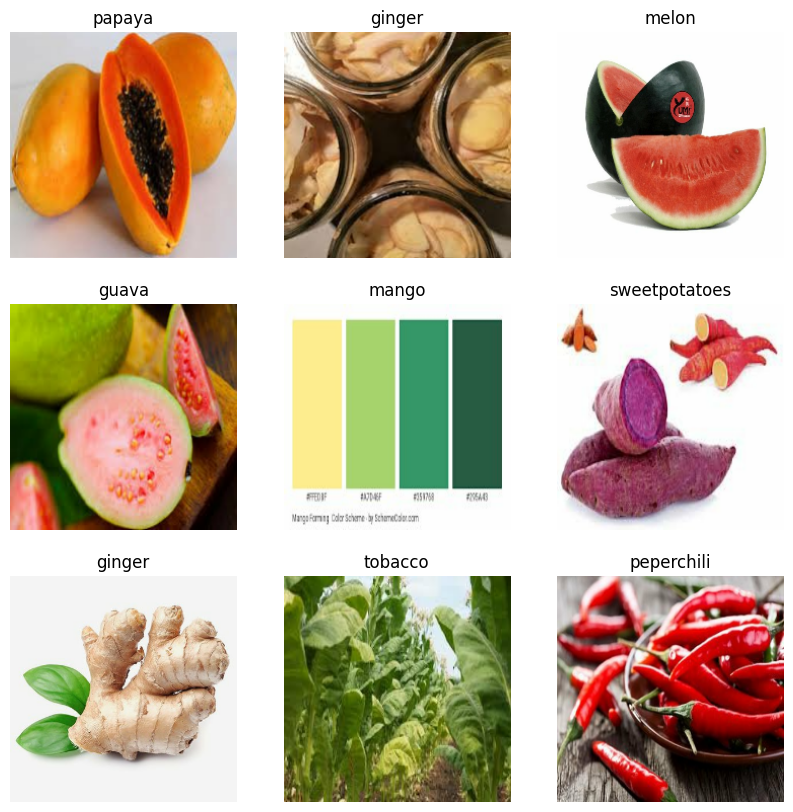

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


NORMALIZING

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# setting pixel values to 1 and 0   `.
print(np.min(first_image), np.max(first_image))


0.0 1.0


CREATING THE MODEL

In [16]:
num_classes = len(class_names)

model = Sequential([#RELU ACTIVATION : Rectified Linear Unit A(x) = MAX(0,x)
    #non-linear, which means we can easily backpropagate the errors and have multiple layers of neurons being activated by the ReLU function.'''
    #output x if x is positive and 0 if negative'''
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),#Size 3 kernel to prevent overfitting
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

COMPILING THE MODEL

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#CROSSENTROPY loss function
              metrics=['accuracy'])

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


657/657 ━━━━━━━━━━━━━━━━━━━━ 497s 748ms/step - accuracy: 0.0672 - loss: 27.9808 - val_accuracy: 0.1183 - val_loss: 3.2293
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 454s 690ms/step - accuracy: 0.2528 - loss: 2.7370 - val_accuracy: 0.2840 - val_loss: 2.8146
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 396s 603ms/step - accuracy: 0.5500 - loss: 1.6495 - val_accuracy: 0.4183 - val_loss: 2.8846
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 381s 580ms/step - accuracy: 0.7507 - loss: 0.8813 - val_accuracy: 0.4563 - val_loss: 3.0243
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 461s 702ms/step - accuracy: 0.8464 - loss: 0.5496 - val_accuracy: 0.4713 - val_loss: 3.6085
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 318s 479ms/step - accuracy: 0.8918 - loss: 0.3540 - val_accuracy: 0.4770 - val_loss: 4.0199
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 444s 676ms/step - accuracy: 0.8987 - loss: 0.3060 - val_accuracy: 0.4853 - val_loss: 4.4076
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 398s 606ms/step - accuracy: 0.9113 - loss: 0.2

Visuallization of the model

In [19]:
model.save('preoverfittingprevention.h5')

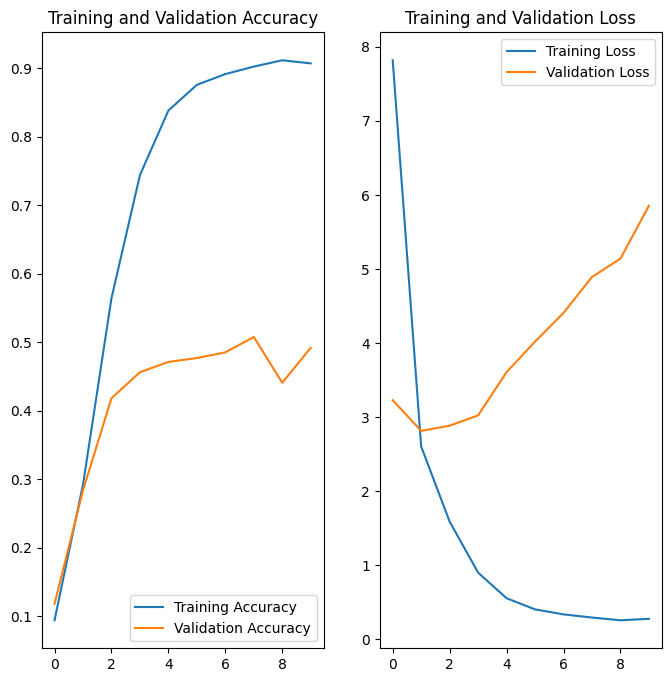

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TO PREVENT OVERFITTING

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\anddk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 336s 512ms/step - accuracy: 0.9289 - loss: 0.1959 - val_accuracy: 0.4890 - val_loss: 6.7080
Epoch 2/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 357s 543ms/step - accuracy: 0.9281 - loss: 0.2078 - val_accuracy: 0.5063 - val_loss: 5.9692
Epoch 3/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 395s 602ms/step - accuracy: 0.9240 - loss: 0.2180 - val_accuracy: 0.5077 - val_loss: 7.2877
Epoch 4/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 438s 668ms/step - accuracy: 0.9376 - loss: 0.1817 - val_accuracy: 0.4983 - val_loss: 5.9123
Epoch 5/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 406s 617ms/step - accuracy: 0.9281 - loss: 0.1997 - val_accuracy: 0.5103 - val_loss: 6.5468
Epoch 6/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 416s 634ms/step - accuracy: 0.9397 - loss: 0.1562 - val_accuracy: 0.5150 - val_loss: 7.1115
Epoch 7/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 426s 649ms/step - accuracy: 0.9383 - loss: 0.1689 - val_accuracy: 0.5027 - val_loss: 7.8027
Epoch 8/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 349s 532ms/step - accuracy: 0.9255 -

VISUALIZING TRAINING RESULTS

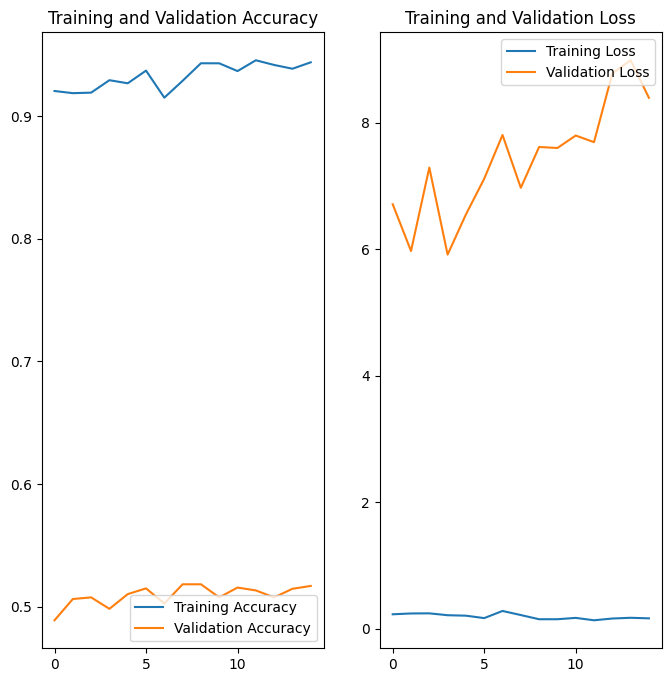

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model.save('model/postplants.h5')
model.save('model/postplants.keras')

PRECTION ON NEW DATA

In [39]:
image_path = 'archive/test/papaya/papaya800'#['archive/test/papaya/papaya800.jpg','archive\test\papaya\papaya835.jpg','archive\test\papaya\papaya895.jpg']

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
    )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

FileNotFoundError: [Errno 2] No such file or directory: 'archive/test/papaya/papaya800'